In [1]:
# https://github.com/aws/amazon-sagemaker-examples/blob/main/introduction_to_amazon_algorithms/jumpstart_upscaling/Amazon_JumpStart_Upscaling.ipynb

In [1]:
# Usando el modelo customizado con codigo de inferencia que considera:
# pipeline.enable_attention_slicing('auto')
# pipeline.set_use_memory_efficient_attention_xformers(True)
# torch.cuda.empty_cache() 

# Normalmente el endpoint realtime tiene timeout. Construyendo entonces un endpoint para inferencia async

In [26]:
import sagemaker, boto3, json
import requests
from io import BytesIO
from datetime import datetime
import pytz
import time
from botocore.exceptions import ClientError

from sagemaker import get_execution_role
from IPython.display import Image

aws_role = get_execution_role()
aws_region = boto3.Session().region_name
sess = sagemaker.Session()

boto_session = boto3.session.Session()


In [6]:
from sagemaker import image_uris, model_uris, script_uris, hyperparameters
from sagemaker.model import Model
from sagemaker.predictor import Predictor
from sagemaker.utils import name_from_base

(model_id, model_version,) = ("model-upscaling-stabilityai-stable-diffusion-x4-upscaler-fp16","*",)

# Instances with more GPU memory supports generation of larger images.
# So, please select instance types such as ml.g5.2xlarge if you want to generate a very large image.
#inference_instance_type = "ml.p3.2xlarge"
inference_instance_type = "ml.g5.xlarge"


# Retrieve the inference docker container uri. This is the base HuggingFace container image for the default model above.
deploy_image_uri = image_uris.retrieve(
    region=None,
    framework=None,  # automatically inferred from model_id
    image_scope="inference",
    model_id=model_id,
    model_version=model_version,
    instance_type=inference_instance_type,
)
deploy_image_uri

'763104351884.dkr.ecr.us-east-1.amazonaws.com/huggingface-pytorch-inference:1.10.2-transformers4.17.0-gpu-py38-cu113-ubuntu20.04'

In [12]:
model_uri = "s3://844626608976-sagemaker-us-east-1/infer-prepack-model-upscaling-stabilityai-stable-diffusion-x4-upscaler-fp16-vgarriden.tar.gz"
s3_bucket = "844626608976-sagemaker-us-east-1"
output_prefix = "inferences"



santiago_timezone = pytz.timezone("America/Santiago")
now = datetime.now(santiago_timezone)

base_name =  f"sd-upscaler-x4-{now.day:02d}-{now.hour:02d}-{now.minute:02d}"
model_name = f"{base_name}-model"
endpoint_name = f"{base_name}-endpoint"


## 1.1 Sagemaker Model
Instructions from: https://github.com/aws/amazon-sagemaker-examples/blob/main/async-inference/Async-Inference-Walkthrough-SageMaker-Python-SDK.ipynb

In [9]:
# Create the SageMaker model instance
model = Model(
    image_uri=deploy_image_uri,
    model_data=model_uri,
    role=aws_role,
    predictor_cls=Predictor,
    name=model_name,
)

## 1.2 Async Config

In [15]:
from sagemaker.async_inference.async_inference_config import AsyncInferenceConfig

async_config = AsyncInferenceConfig(
    output_path=f"s3://{s3_bucket}/{output_prefix}/output",
    max_concurrent_invocations_per_instance=1,
    failure_path= f"s3://{s3_bucket}/{output_prefix}/fail",

    # Optionally specify Amazon SNS topics
    # notification_config = {
    # "SuccessTopic": "arn:aws:sns:<aws-region>:<account-id>:<topic-name>",
    # "ErrorTopic": "arn:aws:sns:<aws-region>:<account-id>:<topic-name>",
    # }
)

## 1.3 Endpoint

In [17]:
async_predictor = model.deploy(
    async_inference_config=async_config,
    instance_type=inference_instance_type,
    initial_instance_count=1,
    endpoint_name=endpoint_name,
)

-----------!

## Helpers

In [55]:
import base64
import matplotlib.pyplot as plt
import numpy as np

input_prefix = "original"
def upload_file(input_location, content_type):
    prefix = f"{input_prefix}"
    return sess.upload_data(
        input_location,
        bucket=s3_bucket,
        key_prefix=prefix,
        extra_args={"ContentType": content_type},
    )



def convert_img2payload(img_location, prompt):
    
    filepart = ''.join(img_location.split('.')[:-1])
    payload_location = f"{filepart}.payload"
    
    with open(img_location, "rb") as f:
        low_res_image_bytes = f.read()
    encoded_image = base64.b64encode(bytearray(low_res_image_bytes)).decode()

    payload = {
        "prompt": prompt,
        "image": encoded_image,
        "num_inference_steps": 75,
        "guidance_scale": 9.0,
        "noise_level": 20
    }

    
    with open(payload_location, "w") as ft:
        json.dump(payload,ft)
        #ft.write(json.dumps(payload))

    return payload_location

def invoke_model(photo_location, prompt):
    payload_location = convert_img2payload(photo_location,prompt)
    input_1_s3_location = upload_file(payload_location, content_type='application/json;jpeg')
    response = sm_runtime.invoke_endpoint_async(EndpointName=endpoint_name, InputLocation=input_1_s3_location, Accept='application/json;jpeg')
    output_location = response["OutputLocation"]
    failure_location = response["FailureLocation"]
    print(f"OutputLocation: {output_location}")
    print(f"FailureLocation: {failure_location}")
    return output_location, failure_location


def wait_for_invoke_async(out_loc, fail_loc=False):
    counter = 0
    while True:
        res = get_invoke_async(out_loc, fail_loc)
        if not (res):
            print (counter, 's')
            counter +=10
            time.sleep(10)
            
        else:
            return res
        
def get_invoke_async(out_loc, fail_loc=False):
    out_bucket, out_key = get_parts(out_loc)
    output = get_object(out_bucket, out_key)
    
    if not(output):
        print('No output...', end='')
    else:
        return output
    
    if fail_loc:
        fail_bucket, fail_key = get_parts(fail_loc)
        failure = get_object(fail_bucket, fail_key)
        if not(failure): 
            print ('no failure...', end='')
        else: 
            return failure
            
    return False
    
def get_parts(s3_loc):
    parts = s3_loc.split('s3://')[1].split('/')
    return parts[0], '/'.join(parts[1:])

def get_object(buck, key):
    try:
        return sess.read_s3_file(bucket=buck, key_prefix=key)
    except ClientError as e:
        return False
    



def query(model_predictor, payload, content_type, accept):
    """Query the model predictor."""

    query_response = model_predictor.predict(
        payload,
        {
            "ContentType": content_type,
            "Accept": accept,
        },
    )
    return query_response


def parse_response(query_response):
    """Parse response and return the generated images and prompt."""

    response_dict = json.loads(query_response)
    return response_dict["generated_images"], response_dict["prompt"]


def display_img_and_prompt(img, prmpt):
    """Display the generated image."""
    plt.figure(figsize=(12, 12))
    plt.imshow(np.array(img))
    plt.axis("off")
    plt.title(prmpt)
    plt.show()


## Asyncronous Inference

In [68]:
# Si es detras de una Funcion Lambda,poner los 
# topics Correspondientes para notificar la lambda de post-procesamiento
output_location,failure_location = invoke_model('upsampled_cat.png', "a white cat")

OutputLocation: s3://844626608976-sagemaker-us-east-1/inferences/output/0a0f9972-8d99-44ff-a997-d333b0161448.out
FailureLocation: s3://844626608976-sagemaker-us-east-1/inferences/fail/0a0f9972-8d99-44ff-a997-d333b0161448-error.out


In [69]:
output = wait_for_invoke_async(output_location, failure_location)

No output...no failure...0 s
No output...no failure...10 s
No output...no failure...20 s
No output...no failure...30 s
No output...no failure...40 s
No output...no failure...50 s
No output...no failure...60 s
No output...no failure...70 s
No output...no failure...80 s
No output...no failure...90 s
No output...no failure...100 s
No output...no failure...110 s
No output...no failure...120 s
No output...no failure...130 s
No output...no failure...140 s
No output...no failure...150 s
No output...no failure...160 s
No output...no failure...170 s
No output...no failure...180 s
No output...no failure...190 s
No output...no failure...200 s
No output...no failure...210 s
No output...no failure...220 s


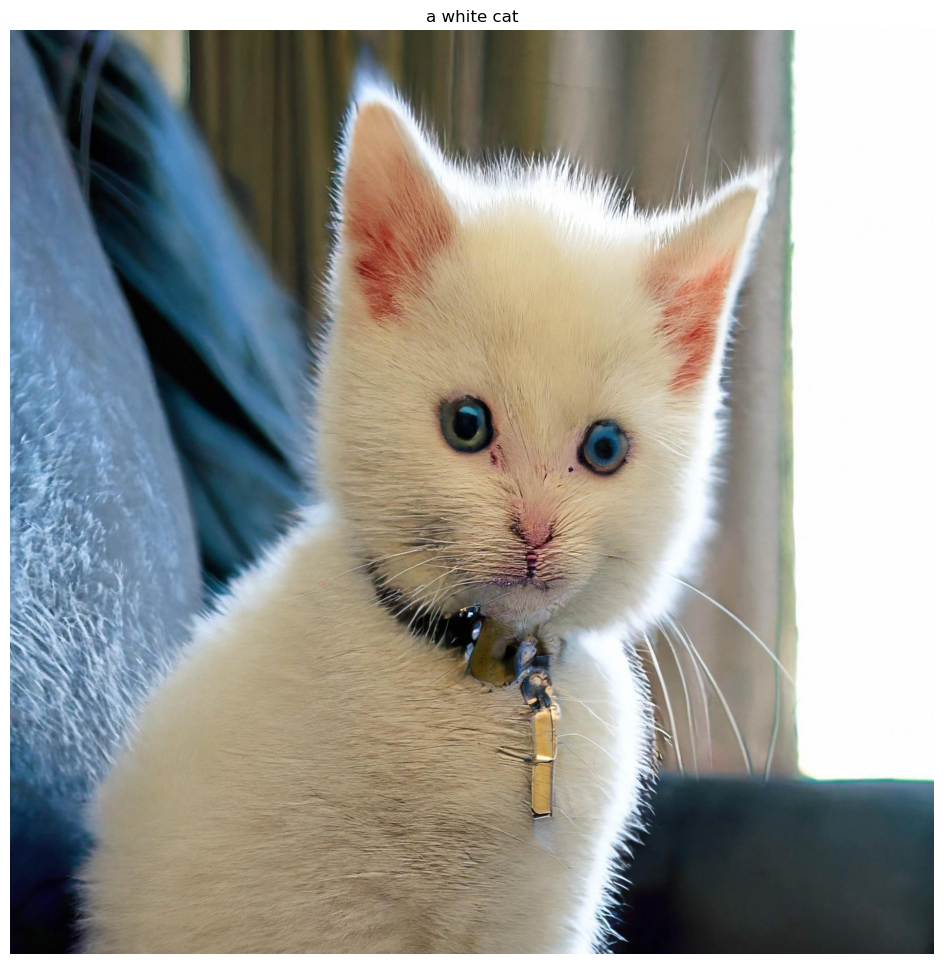

In [70]:
generated_images, prompt = parse_response(output)
generated_image = generated_images[0]
from PIL import Image
from io import BytesIO
generated_image_decoded = BytesIO(base64.b64decode(generated_image.encode()))
generated_image_rgb = Image.open(generated_image_decoded).convert("RGB")
# You can save the generated image by calling generated_image_rgb.save('upscaled_cat_image.jpg')
display_img_and_prompt(generated_image_rgb, prompt)

In [73]:
generated_image_rgb.save('superscaled_cat2.jpg')

In [74]:
generated_image_rgb.height, generated_image_rgb.height

(2048, 2048)